In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import numpy as np

df = pd.read_csv("ETH.csv")
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').reset_index(drop=True)
df['volume_delta'] = df['volume'].diff()
df['volatility_delta'] = df['volatility'].diff()
df = df.dropna().reset_index(drop=True)


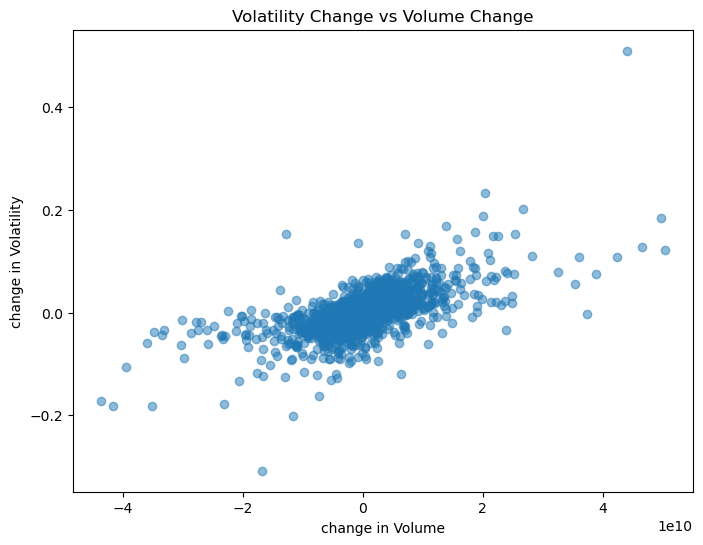

In [2]:
plt.figure(figsize=(8,6))
plt.scatter(df['volume_delta'], df['volatility_delta'], alpha=0.5)
plt.xlabel('change in Volume')
plt.ylabel('change in Volatility')
plt.title('Volatility Change vs Volume Change')
plt.show()


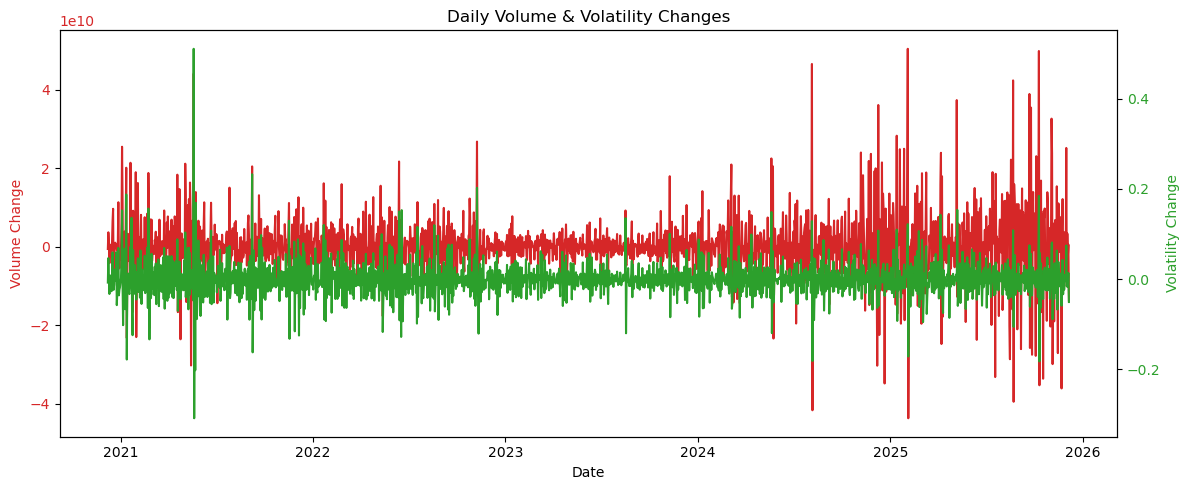

In [3]:
fig, ax1 = plt.subplots(figsize=(12,5))
color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Volume Change', color=color)
ax1.plot(df['date'], df['volume_delta'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('Volatility Change', color=color)
ax2.plot(df['date'], df['volatility_delta'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Daily Volume & Volatility Changes')
fig.tight_layout()
plt.show()


The Pearson correlation coefficient measures the linear relationship between two variables. It is given by:

$$r = \frac{\sum_{i=1}^{n}(x_i - \bar{x})(y_i - \bar{y})}{\sqrt{\sum_{i=1}^{n}(x_i - \bar{x})^2}\sqrt{\sum_{i=1}^{n}(y_i - \bar{y})^2}}$$


In [4]:
correlation = df['volume_delta'].corr(df['volatility_delta'])
print(f"Pearson Correlation: {correlation:.4f}")


Pearson Correlation: 0.6541


### Model 1: Linear Regression

In a simple linear regression, we model the predicted output as a straight-line
function of the input variable. The expression for the model is

$$
\hat{y} = a + bx
$$

where \(a\) is the intercept (the value of the model when \(x = 0\)) and \(b\) is
the slope that determines how \(\hat{y}\) changes as \(x\) varies.


In [5]:
X = df['volume_delta'].values
y = df['volatility_delta'].values

def linear_model(x, a, b):
    return a * x + b

params_linear, _ = curve_fit(linear_model, X, y)
y_pred_linear = linear_model(X, *params_linear)
r2_linear = r2_score(y, y_pred_linear)

print(f"Linear: y = {params_linear[0]:.6e}*x + {params_linear[1]:.6e}")
print(f"R² = {r2_linear:.4f}")


Linear: y = 3.397361e-12*x + -1.698128e-05
R² = 0.4279


### Model 2 : Polynomial Regression

A polynomial model lets the prediction curve instead of forming a straight line.
A degree-\(n\) polynomial looks like:

$$
\hat{y} = a_0 + a_1 x + a_2 x^2 + \cdots + a_n x^n
$$


In [6]:
def poly2_model(x, a, b, c):
    return a * x**2 + b * x + c

params_poly2, _ = curve_fit(poly2_model, X, y)
y_pred_poly2 = poly2_model(X, *params_poly2)
r2_poly2 = r2_score(y, y_pred_poly2)

print(f"Polynomial: y = {params_poly2[0]:.6e}*x² + {params_poly2[1]:.6e}*x + {params_poly2[2]:.6e}")
print(f"R² = {r2_poly2:.4f}")


Polynomial: y = 1.489947e-23*x² + 3.359660e-12*x + -9.303378e-04
R² = 0.4327


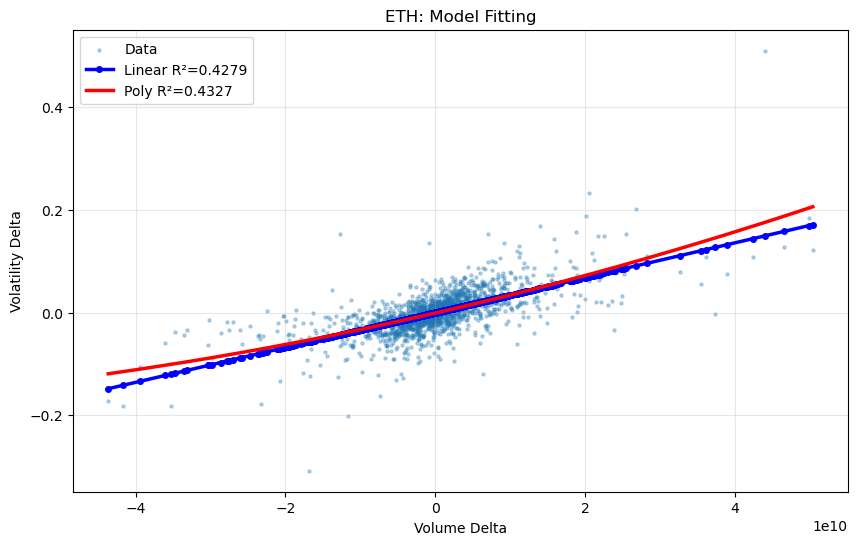

In [7]:
plt.figure(figsize=(10, 6))
plt.scatter(X, y, alpha=0.3, s=5, label='Data')

X_sorted = np.sort(X)
plt.plot(X_sorted, linear_model(X_sorted, *params_linear), 'blue', linestyle='-', marker='o', markersize=4, linewidth=2.5, label=f'Linear R²={r2_linear:.4f}')
plt.plot(X_sorted, poly2_model(X_sorted, *params_poly2), 'red', linestyle='-', linewidth=2.5, label=f'Poly R²={r2_poly2:.4f}')
plt.xlabel('Volume Delta')
plt.ylabel('Volatility Delta')
plt.title('ETH: Model Fitting')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [8]:
df_clean = df.copy()
volume_changes = df_clean['volume_delta'].values.reshape(-1, 1)
volatility_changes = df_clean['volatility_delta'].values

linear_model = LinearRegression()
linear_model.fit(volume_changes, volatility_changes)

linear_predictions = linear_model.predict(volume_changes)
linear_r2 = r2_score(volatility_changes, linear_predictions)

slope = linear_model.coef_[0]
intercept = linear_model.intercept_

print(f"R² Score: {linear_r2:.4f} ({linear_r2*100:.2f}%)")
print("\nLinear Equation:")
print(f"Δσ = {slope:.6e} × ΔV + {intercept:.6e}")


R² Score: 0.4279 (42.79%)

Linear Equation:
Δσ = 3.397361e-12 × ΔV + -1.696679e-05


In [9]:
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(volume_changes)

poly_model = LinearRegression()
poly_model.fit(X_poly, volatility_changes)

poly_predictions = poly_model.predict(X_poly)
poly_r2 = r2_score(volatility_changes, poly_predictions)

print(f"\nLinear Model (Degree 1):     R² = {linear_r2:.4f} ({linear_r2*100:.2f}%)")
print(f"Polynomial Model (Degree 2): R² = {poly_r2:.4f} ({poly_r2*100:.2f}%)")
print(f"\nImprovement: {poly_r2 - linear_r2:.4f} ({(poly_r2 - linear_r2)*100:.2f}%)")

if poly_r2 > linear_r2:
    print(f"Polynomial is better by {(poly_r2 - linear_r2)*100:.2f}%")
else:
    print(" Linear model is actually better")



Linear Model (Degree 1):     R² = 0.4279 (42.79%)
Polynomial Model (Degree 2): R² = 0.4327 (43.27%)

Improvement: 0.0048 (0.48%)
Polynomial is better by 0.48%


### R² Score Calculation

The coefficient of determination quantifies the quality of the model’s fit to the observed data.

$$R^2 = 1 - \frac{\sum_{i=1}^{n}(y_i - \hat{y}_i)^2}{\sum_{i=1}^{n}(y_i - \bar{y})^2}$$

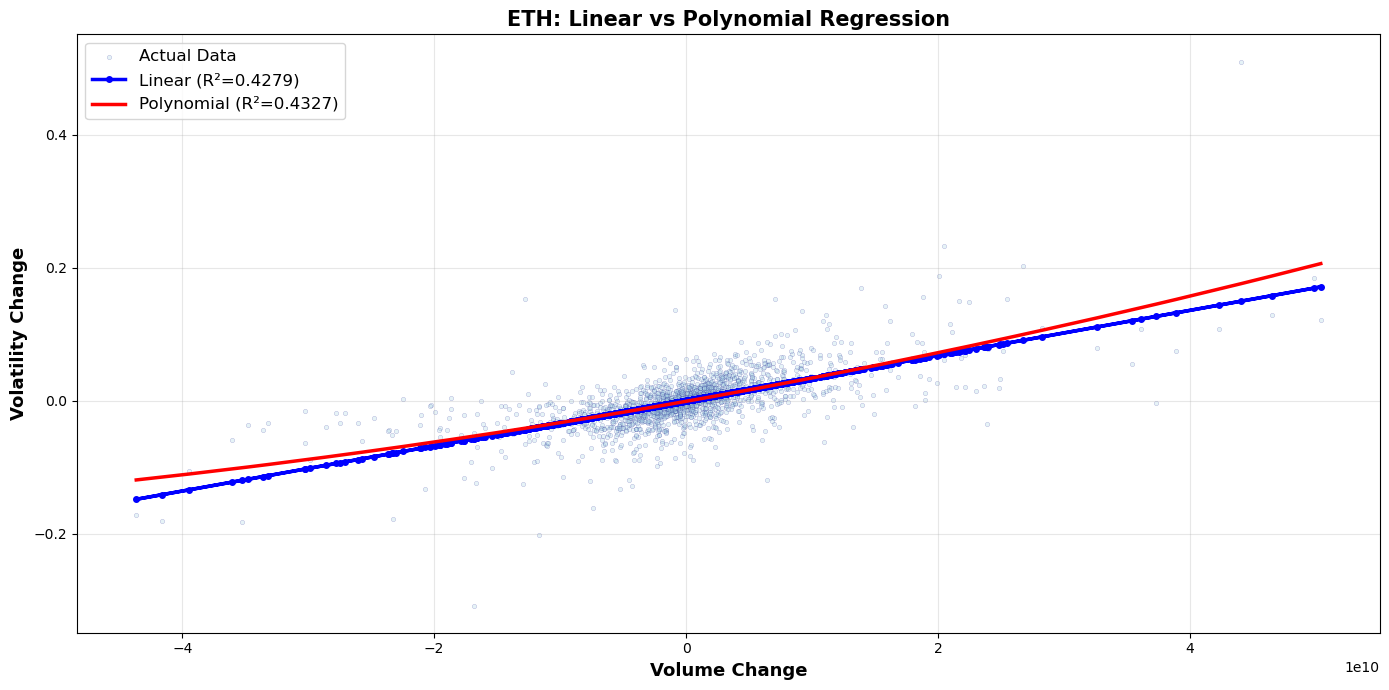

In [10]:
plt.figure(figsize=(14, 7))
plt.scatter(volume_changes, volatility_changes, 
           alpha=0.3, s=10, color='lightblue', 
           label='Actual Data', edgecolors='navy', linewidth=0.3)

plt.plot(volume_changes, linear_predictions, color='blue', linestyle='-', marker='o', markersize=4, linewidth=2.5, label=f'Linear (R²={linear_r2:.4f})')

sorted_idx = np.argsort(volume_changes.flatten())
plt.plot(volume_changes[sorted_idx], poly_predictions[sorted_idx],
         color='red', linestyle='-', linewidth=2.5, label=f'Polynomial (R²={poly_r2:.4f})')

plt.xlabel('Volume Change', fontsize=13, fontweight='bold')
plt.ylabel('Volatility Change', fontsize=13, fontweight='bold')
plt.title('ETH: Linear vs Polynomial Regression', fontsize=15, fontweight='bold')
plt.legend(fontsize=12, loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


For ETH, the polynomial model (degree 2) fits slightly better with R² = 0.4327, improving only 0.48% over the linear model.  
This indicates the relationship between volume change (ΔV) and volatility change (Δσ) is mostly linear.  
Therefore, the linear model is sufficient and easier to interpret for this asset.
